## Portable, Low-Field Magnetic Resonance Imaging Sensitively Detects and Accurately Quantifies Multiple Sclerosis Lesions

**Study Summary**<br /> 
Using manual measurement and automated segmentation, we evaluated the ability of a portable 64mT MRI scanner to characterize MS lesion burden and demonstrated effects of size and intensity on detection.

**About This Document**<br /> 
This jupyter notebook was designed as a companion to the publication's results section. We hope it increases study transparency and allows researchers to reuse relevant code in their own studies. The notebook contains each paragraph from the results section, followed by the code used to derive that section's results. The notebook contains all statistical analyses included in the study. Images containing figure components are presented in the order they appear in the publication. Notebook images are often only a component of a more complex figure in the publication and not all publication figures appear in this companion.

## Abstract

**Background**<br /> 
By lowering barriers to imaging and reaching underserved or debilitated populations, low-cost, portable, low-field MRI could potentially facilitate diagnosis and management of neurological diseases such as multiple sclerosis (MS), screening of populations at risk, and outcome assessment in clinical trials. However, the sensitivity of low-field MRI for MS lesions is unknown.

**Purpose**<br /> 
To determine if white matter lesions can be detected on 64mT low-field MRI, compare automated lesion segmentations and total lesion burden between paired 3T and 64mT scans, and determine what features contribute to detection accuracy.

**Materials & Methods**<br /> 
In this prospective, cross-sectional study, same-day brain MRI (FLAIR, T1 and T2) scans were collected from adults with known or suspected MS using 3T (Siemens) and 64mT (Hyperfine) scanners at two centers. MRI was performed between October 2020 and April 2021. Images were reviewed by neuroradiologists. MS lesions were measured manually and segmented using an automated algorithm. Statistical analyses assessed accuracy and variability of segmentations across scanners and systematic scanner biases in automated volumetric measurements.

**Results**<br /> 
The study included 36 patients (32 women; mean age, 50±14 years). Lesions were identified on 64mT scans in 97% (31/32) of patients with confirmed MS. The smallest lesions manually detected were 6.6±2.0 mm in maximum diameter at 64mT vs 2.3±0.9 mm at 3T. Automated lesion burden estimates were highly correlated between 3T and 64mT scans (r=0.89, p<0.001). Bland-Altman analysis identified bias in 64mT segmentations (mean=1.4ml, limits of agreement=-18.9–16.2 ml), which over-estimated low lesion burden and under-estimated high burden. Visual inspection revealed over-segmentation was driven by flow-related hyperintensities in veins on 64mT FLAIR. Lesion size drove segmentation accuracy, with 83% of lesions >0.5 ml and all lesions >1.5 ml being detected.

**Conclusions**<br /> 
In established MS, a portable 64mT MRI scanner can identify white matter lesions, and burden estimates are consistent with 3T scans.


## Import python modules

This section import python modules that were used in the study.

In [1]:
%%capture

# import relevant modules
!pip install --upgrade pip # make sure pip is up to date
!pip install antspyx # install ANTs
!pip install pyCompare # used for BA-plots 
!pip install pingouin # used for ICC stats

import pyCompare
import ants
import numpy as np
import glob
import os
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
import sklearn
import pathlib
import pingouin as pg

/Users/tcarnold/opt/anaconda3/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning:

The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.



## Helper Functions
This section defines functions that are used multiple times throughout the code.

In [2]:
# performs a two sample t-test + print out basic stats
def mean_std(df, var, sig_fig):

    mu = np.mean( df[var] )
    sigma = np.std( df[var])
    print(var + ': ' + str( np.round( mu , sig_fig ) ) + ' +/- ' + str( np.round( sigma , sig_fig ) ) )
    
    return [mu, sigma]

In [3]:
# performs a two sample t-test comparing institutions + print out basic stats
def site_ttest2(var):
    
    print(var)
    print('Site A: ' + str( np.round( np.mean( siteA_df[var] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( siteA_df[var]) , 2 ) ) )
    print('Site B: ' + str( np.round( np.mean( siteB_df[var] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( siteB_df[var]) , 2 ) ) )
    [t,p] = np.round( scipy.stats.ttest_ind( siteA_df[var].dropna() , siteB_df[var].dropna()) , 5 )
    print("Two-sample t-test: t=" + str(t) + ", p=" + str(p))
    print()
    return [t,p]

In [4]:
# performs a paired t-test + print out basic stats
def paired_test(df,label,m1,m2,var):
    
    # get seperate dfs for each measurement
    df_1 = df[df[label]==m1]
    df_2 = df[df[label]==m2]
    
    print(var)
    print(str(m1) + ': ' + str( np.round( np.mean( df_1[var] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( df_1[var]) , 2 ) ) )
    print(str(m2) + ': ' + str( np.round( np.mean( df_2[var] ) , 2 ) ) + ' +/- ' + str( np.round( np.std( df_2[var]) , 2 ) ) )
    [t,p] = np.round( scipy.stats.ttest_rel( df_1[var] , df_2[var], nan_policy='omit') , 5 )
    print("Paired t-test: t=" + str(t) + ", p=" + str(p))
    print()
    return [t,p]

In [5]:
# finds slice with maximal lesion burden
def mask_idx( mask ):
    
    Z = mask.shape[2]
    slice_total = []
    for i in range(0,Z):
        slice_total.append( np.sum(mask.numpy()[:,:,i]) )
    idx = np.argmax(slice_total)
    
    return idx

In [6]:
# Dice similarity function
def dice(pred, true, k = 1):
    
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [7]:
# build table of lesions for an individual subject using connected components analysis
from skimage import measure

def lesion_overlap_intensity(target_mask, pred_mask, img):
    
    # dateframe for holding lesion information
    lesion_df = pd.DataFrame(columns=['lesion_ID', 'vol', 'overlap', 'intensity'])
    
    # identify all unique lesions 
    all_labels = measure.label( target_mask )
    lesion_ID = np.unique(all_labels)[1:] # remove background 

    # plot slice for confirmation
    idx = int( np.round( all_labels.shape[2]/2 ) )

    # add lesion information to dataFrame
    for lesion in lesion_ID:
        lesion_mask = all_labels == lesion
        vol = np.sum(lesion_mask)
        per_overlap = np.sum(pred_mask[lesion_mask]) / vol
        intensity = np.mean( img[lesion_mask] )
        lesion_df = lesion_df.append({'lesion_ID': lesion,
                                      'vol': vol, 
                                      'overlap': per_overlap, 
                                      'intensity': intensity}, 
                                     ignore_index=True)
    return lesion_df

## Results


### Patient Demographics

We collected data from 36 adults with known or suspected MS. The patient population had a mean age of 49.6 (SD: 14.2) years and was composed of 32 women and 4 men (Table 1). The mean duration of disease was 13.7 years (SD: 11.2), and patients had a median EDSS of 1.5 (interquartile range = 2). Patients from site B were significantly older than those from site A (p=0.03, site A: 45.3 years old, site B: 55.7 years old) and had a longer duration of disease (p=0.03, site A: 10.2 years, site B: 18.5 years). Additional demographic information is provided in Table 1. After initial scan review, four patients were excluded from further analysis: One patient had excessive scanner motion, two patients had clinically isolated syndrome (CIS), and one patient had neuromyelitis optica (NMO). All subsequent analyses are based on the remaining 32 patients (Fig 1).

#### Read in demographic datatable and print

In [8]:
demo_df = pd.read_csv('../docs/combined_patient_demographics.csv')
demo_df = demo_df.set_index('ID')
demo_df = demo_df.drop(index='P002') # drop healthy volunteer
demo_df

,Site,Age,Gender,Race,Clinical Phenotype,Disease duration (years),Current DMT,EDSS,New lesion,Contrast (Gadobutrol),Contrast dose (ml),Post-gd delay
ID,,,,,,,,,,,,
P001,Site B,70,F,White,RRMS,15.0,none,2.0,no,yes,5.4,72 mins
P003,Site B,68,M,White,SPMS,43.0,dimethyl fumarate,3.5,no,yes,10.7,none
P004,Site B,67,F,Hispanic,RRMS,33.0,dimethyl fumarate,2.5,no,yes,5.3,none
P005,Site B,63,F,White,RRMS,35.0,teriflunamide,2.5,yes,yes,5.3,none
P006,Site B,33,F,White,RRMS,14.0,diroximel fumarate,2.0,no,yes,7.3,none
P007,Site B,36,F,White,RRMS,5.0,none,1.5,no,yes,6.8,none
P008,Site B,51,F,White,RRMS,22.0,ocralizumab,3.0,no,yes,5.5,none
P009,Site B,60,F,White,RRMS,21.0,none,2.0,no,yes,8.7,none
P010,Site B,50,M,White,CIS,6.0,none,1.0,no,yes,9.4,none


#### Print basic demographic information

In [9]:
# mean +/- standard deviation for continuous variables
[_,_] = mean_std(demo_df, 'Age', 1)
[_,_] = mean_std(demo_df, 'Disease duration (years)', 1)
[_,_] = mean_std(demo_df, 'EDSS', 1)

# EDSS median and IQR
q3, q1 = np.percentile(demo_df['EDSS'], [75 ,25])
iqr = q3 - q1
print('EDSS median = ' + str(np.median(demo_df['EDSS'])) + ', IQR = ', str(iqr) )
      
# counts for discrete variables
print()
print( demo_df['Site'].value_counts() )
print()
print( demo_df['Gender'].value_counts() )
print()
print( demo_df['Clinical Phenotype'].value_counts() )
print()
print( demo_df['Current DMT'].value_counts() )
print()
print( demo_df['New lesion'].value_counts() )


Age: 49.6 +/- 14.2
Disease duration (years): 13.7 +/- 11.2
EDSS: 2.1 +/- 1.2
EDSS median = 1.5, IQR =  2.0

Site A    21
Site B    15
Name: Site, dtype: int64

F    32
M     4
Name: Gender, dtype: int64

RRMS                                                                             28
SPMS                                                                              2
CIS                                                                               2
PMD of Idiopathic Transverse Myelitis with abnormal brain MRI not meeting DIS     1
PPMS                                                                              1
RIS                                                                               1
NMO                                                                               1
Name: Clinical Phenotype, dtype: int64

ocrelizumab                  9
none                         9
ocralizumab                  3
dimethyl fumarate            3
natalizumab                  2
tysabri      

#### Summarize demographic information for each study site

In [10]:
for site in ['Site A','Site B']:
    site_df = demo_df[ demo_df['Site'] == site ]

    print(site + ' DEMOGRAPHICS')
    print()


    # mean +/- standard deviation for continuous variables
    [_,_] = mean_std(site_df, 'Age', 1)
    [_,_] = mean_std(site_df, 'Disease duration (years)', 1)
    [_,_] = mean_std(site_df, 'EDSS', 1)
    q3, q1 = np.percentile(site_df['EDSS'], [75 ,25])
    iqr = q3 - q1
    print('EDSS median = ' + str(np.median(site_df['EDSS'])) + ', IQR = ', str(iqr) )

    # counts for discrete variables
    print()
    print( site_df['Site'].value_counts() )
    print()
    print( site_df['Gender'].value_counts() )
    print()
    print( site_df['Clinical Phenotype'].value_counts() )
    print()
    print( site_df['Current DMT'].value_counts() )
    print()


Site A DEMOGRAPHICS

Age: 45.3 +/- 13.6
Disease duration (years): 10.2 +/- 9.6
EDSS: 2.1 +/- 1.4
EDSS median = 1.5, IQR =  2.0

Site A    21
Name: Site, dtype: int64

F    19
M     2
Name: Gender, dtype: int64

RRMS    18
NMO      1
RIS      1
CIS      1
Name: Clinical Phenotype, dtype: int64

ocrelizumab                  9
none                         3
natalizumab                  2
glatiramer acetate           1
tysabri                      1
aubagio                      1
rituximab                    1
ofatumumab                   1
stopped tecfidera 12/2018    1
fingolimod                   1
Name: Current DMT, dtype: int64

Site B DEMOGRAPHICS

Age: 55.7 +/- 12.7
Disease duration (years): 18.5 +/- 11.5
EDSS: 2.0 +/- 0.9
EDSS median = 2.0, IQR =  1.25

Site B    15
Name: Site, dtype: int64

F    13
M     2
Name: Gender, dtype: int64

RRMS                                                                             10
SPMS                                                             

#### Compare variables across sites using 2 sample t-test

In [11]:
siteA_df = demo_df[ demo_df['Site']=='Site A']
siteB_df = demo_df[ demo_df['Site']=='Site B']
[_,_] = site_ttest2('Age')
[_,_] = site_ttest2('Disease duration (years)')
[_,_] = site_ttest2('EDSS')


Age
Site A: 45.33 +/- 13.65
Site B: 55.67 +/- 12.73
Two-sample t-test: t=-2.23841, p=0.03185

Disease duration (years)
Site A: 10.24 +/- 9.6
Site B: 18.53 +/- 11.45
Two-sample t-test: t=-2.29004, p=0.02835

EDSS
Site A: 2.07 +/- 1.44
Site B: 2.03 +/- 0.9
Two-sample t-test: t=0.0879, p=0.93047



#### Drop patient with excessive motion

In [12]:
demo_df = demo_df.drop(index='P036') # motion in ULF-MRI

### Manual Measurements

MS lesions on 64mT are characterized by T1w hypointensity and T2w/T2-FLAIR hyperintensity, similar to 3T imaging (Fig 2). At 64mT, lesions were identified by at least one rater in 97% (31/32) of patients with confirmed lesions on 3T imaging. In two patients, only one rater identified lesions at 64mT; all other ratings were concordant. The largest and smallest lesions in each image were identified, and the Dmax was recorded. The 64mT scanner showed 100% sensitivity across both raters for detecting WML when there was at least one lesion with Dmax >5 mm (29/32 patients, 91%). Across patients, the mean Dmax for the smallest WML detectable at 64mT and the smallest WML detectable at 3T were 6.62.0 mm and 2.30.9 mm, respectively. There was a significant effect (p=0.007) of scan site on Dmax of the smallest lesions identified on 3T, with smaller lesion sizes for site B patients (1.9±0.6 mm) compared to site A patients (2.5±1.0 mm). There were no significant effects of site on the 64mT lesion measurements or the largest lesion measurements at 3T. 

#### Read in manual measurements

In [13]:
IRR_df = pd.read_excel('../docs/IRR_data_20211005_experts_only.xlsx')
IRR_df = IRR_df.set_index('ID')
IRR_df = IRR_df.drop(index='P002') # drop healthy volunteer
IRR_df = IRR_df.drop(index='P010') # clinically isolated syndrome (CIS)
IRR_df = IRR_df.drop(index='P022') # neuromyelitis optica (NMO)
IRR_df = IRR_df.drop(index='P030') # clinically isolated syndrome (CIS)
IRR_df = IRR_df.drop(index='P036') # motion in ULF-MRI
IRR_df.head()

,Site,Exam,Rater,Dmax SL-ULF (mm),Dmax LL-ULF (mm),Dmax SL-HF (mm),Dmax LL-HF (mm)
ID,,,,,,,
P001,Site B,1,1,5.2,13.7,1.7,13.1
P003,Site B,3,1,5.6,17.1,2.2,15.2
P004,Site B,4,1,7.9,23.4,3.1,22.2
P005,Site B,5,1,8.4,12.4,2.1,12.7
P006,Site B,6,1,8.3,4.3,2.4,9.0


#### get detection rate and print manual measurement summary statistics

In [14]:
# get number of subjects read as positive by at least one rater
N_ULF = np.sum( np.logical_or( ~IRR_df[IRR_df['Rater']==2]['Dmax LL-ULF (mm)'].isnull(), \
                       ~IRR_df[IRR_df['Rater']==1]['Dmax LL-ULF (mm)'].isnull() ) )
N_HF = np.sum( np.logical_or( ~IRR_df[IRR_df['Rater']==2]['Dmax LL-HF (mm)'].isnull(), \
                       ~IRR_df[IRR_df['Rater']==1]['Dmax LL-HF (mm)'].isnull() ) )

print('ULF-MRI manual lesion detection rate: '+ str(N_ULF) + '/' + str(N_HF) + ' = ' + str( np.round(N_ULF/N_HF*100, 1) ) + '%') # Excludeds P030 (CIS, so no lesions), Includes P010 (CIS, but had lesions on 3T).


# print mean and standard deviation
print()
print('mean and standard deviation')
[_,_] = mean_std(IRR_df, 'Dmax SL-ULF (mm)', 1)
[_,_] = mean_std(IRR_df, 'Dmax SL-HF (mm)', 1)
[_,_] = mean_std(IRR_df, 'Dmax LL-ULF (mm)', 1)
[_,_] = mean_std(IRR_df, 'Dmax LL-HF (mm)', 1)


ULF-MRI manual lesion detection rate: 31/32 = 96.9%

mean and standard deviation
Dmax SL-ULF (mm): 6.6 +/- 2.0
Dmax SL-HF (mm): 2.3 +/- 0.9
Dmax LL-ULF (mm): 14.9 +/- 6.6
Dmax LL-HF (mm): 16.7 +/- 9.2


#### check for site and rater effects

In [15]:
# check for site effects
print()
print('site level effects')
siteA_df = IRR_df[IRR_df['Site'] =='Site A']
siteB_df = IRR_df[IRR_df['Site'] =='Site B']
[_,_] = site_ttest2('Dmax SL-ULF (mm)')
[_,_] = site_ttest2('Dmax SL-HF (mm)')
[_,_] = site_ttest2('Dmax LL-ULF (mm)')
[_,_] = site_ttest2('Dmax LL-HF (mm)')

# check for rater differences
print()
print('Compare Rater 1 and Rater 2 measurements')
paired_test(IRR_df,'Rater',1,2,'Dmax SL-ULF (mm)')
paired_test(IRR_df,'Rater',1,2,'Dmax SL-HF (mm)')
paired_test(IRR_df,'Rater',1,2,'Dmax LL-ULF (mm)')
paired_test(IRR_df,'Rater',1,2,'Dmax LL-HF (mm)')


site level effects
Dmax SL-ULF (mm)
Site A: 6.8 +/- 2.35
Site B: 6.35 +/- 1.5
Two-sample t-test: t=0.82575, p=0.41233

Dmax SL-HF (mm)
Site A: 2.53 +/- 0.99
Site B: 1.94 +/- 0.55
Two-sample t-test: t=2.78992, p=0.007

Dmax LL-ULF (mm)
Site A: 15.55 +/- 6.85
Site B: 14.09 +/- 6.07
Two-sample t-test: t=0.8491, p=0.39932

Dmax LL-HF (mm)
Site A: 18.45 +/- 10.39
Site B: 14.47 +/- 6.86
Two-sample t-test: t=1.7251, p=0.08949


Compare Rater 1 and Rater 2 measurements
Dmax SL-ULF (mm)
1: 7.79 +/- 2.14
2: 5.49 +/- 1.11
Paired t-test: t=5.13505, p=2e-05

Dmax SL-HF (mm)
1: 2.66 +/- 0.96
2: 1.88 +/- 0.55
Paired t-test: t=4.80665, p=4e-05

Dmax LL-ULF (mm)
1: 15.21 +/- 7.27
2: 14.64 +/- 5.82
Paired t-test: t=-0.07238, p=0.94281

Dmax LL-HF (mm)
1: 18.92 +/- 11.13
2: 14.5 +/- 6.06
Paired t-test: t=3.14584, p=0.00364



[3.14584, 0.00364]

#### check for scanner differences

In [16]:

print('Compare 64mT and 3T measurements')
[t,p] = np.round( scipy.stats.ttest_ind( IRR_df['Dmax LL-ULF (mm)'] , IRR_df['Dmax LL-HF (mm)'], nan_policy='omit') , 5 )
print('large lesion: t=' + str(t) + ', p=' + str(p) )
[t,p] = np.round( scipy.stats.ttest_ind( IRR_df['Dmax SL-ULF (mm)'] , IRR_df['Dmax SL-HF (mm)'], nan_policy='omit') , 5 )
print('small lesion: t=' + str(t) + ', p=' + str(p) )

Compare 64mT and 3T measurements
large lesion: t=-1.22788, p=0.22186
small lesion: t=15.40754, p=0.0


### Interrater Reliability
The smallest and largest lesion in each image were independently measured by two raters to assess interrater reliability (Fig E2). The ICC for each patient's largest lesion measured at 3T and 64mT was 0.56 (CI=[0.23–0.77]) and 0.85 (CI=[0.70-0.92]) respectively, indicating high interrater reliability for large lesions on both scanners. However, when measuring each patient’s smallest lesion there was a low relationship between raters at both 64mT (ICC=0.03 CI=[0-0.27]) and 3T (ICC=0.23, CI=[0-0.52]). This indicates that measurements made by raters were no more reliable at 3T than 64mT. Of note, the average smallest lesions detected (3T: 2.30.9 mm, 64mT: 6.62.0 mm) approached the respective resolution limits for each system (3T: 1 mm, 64mT: 5 mm).


#### boxplots of lesion measurements by rater

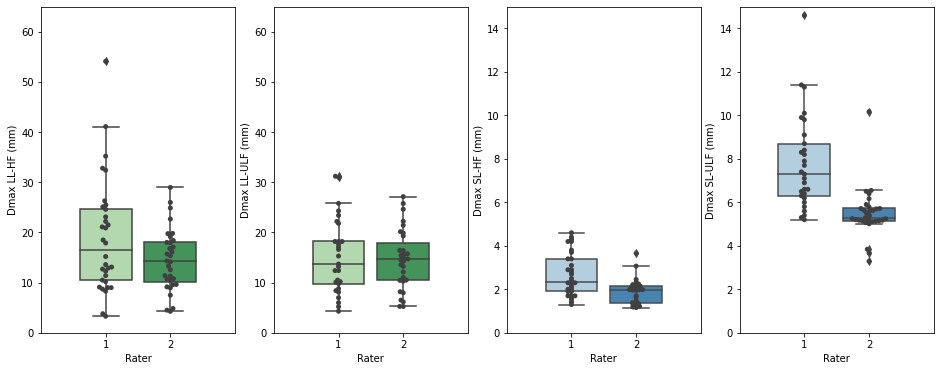

In [17]:
fig = plt.figure(figsize = (16,6))
ax1 = fig.add_subplot(1,4,1)
ax1 = sns.boxplot(y="Dmax LL-HF (mm)", x='Rater', data=IRR_df, orient="v", palette="Greens")
ax1 = sns.swarmplot(y="Dmax LL-HF (mm)", x='Rater', data=IRR_df, orient="v", color=".25")
plt.axis([-1, 2, 0, 55])

ax2 = fig.add_subplot(1,4,2)
ax2 = sns.boxplot(y="Dmax LL-ULF (mm)", x='Rater', data=IRR_df, orient="v", palette="Greens")
ax2 = sns.swarmplot(y="Dmax LL-ULF (mm)", x='Rater', data=IRR_df, orient="v", color=".25")
plt.axis([-1, 2, 0, 55])

ax3 = fig.add_subplot(1,4,3)
ax3 = sns.boxplot(y="Dmax SL-HF (mm)", x='Rater', data=IRR_df, orient="v", palette="Blues")
ax3 = sns.swarmplot(y="Dmax SL-HF (mm)", x='Rater', data=IRR_df, orient="v", color=".25")
plt.axis([-1, 2, 0, 15])

ax4 = fig.add_subplot(1,4,4)
ax4 = sns.boxplot(y="Dmax SL-ULF (mm)", x='Rater', data=IRR_df, orient="v", palette="Blues")
ax4 = sns.swarmplot(y="Dmax SL-ULF (mm)", x='Rater', data=IRR_df, orient="v", color=".25")
plt.axis([-1, 2, 0, 15])
plt.savefig('../output/manuscript_figures/raw_figures/IRR.tif', dpi=600)

#### Intraclass correlation for each group of lesion/scanner measurements

In [18]:
# IRR - Large Lesion HF
icc = pg.intraclass_corr(data=IRR_df, targets='Exam', raters='Rater', ratings='Dmax LL-HF (mm)', nan_policy='omit')
icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.537103,3.320616,31,32,0.000557,"[0.24, 0.74]"
ICC2,Single random raters,0.559292,4.243779,31,31,0.000062,"[0.22, 0.77]"
ICC3,Single fixed raters,0.618596,4.243779,31,31,0.000062,"[0.35, 0.79]"
ICC1k,Average raters absolute,0.698851,3.320616,31,32,0.000557,"[0.39, 0.85]"
ICC2k,Average random raters,0.717366,4.243779,31,31,0.000062,"[0.37, 0.87]"
ICC3k,Average fixed raters,0.764361,4.243779,31,31,0.000062,"[0.52, 0.88]"


In [19]:
# IRR - Large Lesion ULF
icc = pg.intraclass_corr(data=IRR_df, targets='Exam', raters='Rater', ratings='Dmax LL-ULF (mm)', nan_policy='omit')
icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.845777,11.968258,28,29,1.175381e-09,"[0.7, 0.92]"
ICC2,Single random raters,0.845354,11.557722,28,28,3.037521e-09,"[0.7, 0.92]"
ICC3,Single fixed raters,0.840735,11.557722,28,28,3.037521e-09,"[0.69, 0.92]"
ICC1k,Average raters absolute,0.916446,11.968258,28,29,1.175381e-09,"[0.82, 0.96]"
ICC2k,Average random raters,0.916197,11.557722,28,28,3.037521e-09,"[0.82, 0.96]"
ICC3k,Average fixed raters,0.913478,11.557722,28,28,3.037521e-09,"[0.82, 0.96]"


In [20]:
# IRR - Small Lesion HF
icc = pg.intraclass_corr(data=IRR_df, targets='Exam', raters='Rater', ratings='Dmax SL-HF (mm)', nan_policy='omit')
icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,0.089564,1.196750,31,32,0.307912,"[-0.26, 0.42]"
ICC2,Single random raters,0.232332,2.023399,31,31,0.027001,"[-0.07, 0.52]"
ICC3,Single fixed raters,0.338493,2.023399,31,31,0.027001,"[-0.01, 0.61]"
ICC1k,Average raters absolute,0.164403,1.196750,31,32,0.307912,"[-0.7, 0.59]"
ICC2k,Average random raters,0.377061,2.023399,31,31,0.027001,"[-0.16, 0.68]"
ICC3k,Average fixed raters,0.505782,2.023399,31,31,0.027001,"[-0.01, 0.76]"


In [21]:
# IRR - Small Lesion ULF
icc = pg.intraclass_corr(data=IRR_df, targets='Exam', raters='Rater', ratings='Dmax SL-ULF (mm)', nan_policy='omit')
icc.set_index('Type')

,Description,ICC,F,df1,df2,pval,CI95%
Type,,,,,,,
ICC1,Single raters absolute,-0.247220,0.603566,28,29,0.907362,"[-0.56, 0.12]"
ICC2,Single random raters,0.033896,1.131556,28,28,0.372973,"[-0.14, 0.27]"
ICC3,Single fixed raters,0.061718,1.131556,28,28,0.372973,"[-0.31, 0.41]"
ICC1k,Average raters absolute,-0.656819,0.603566,28,29,0.907362,"[-2.5, 0.22]"
ICC2k,Average random raters,0.065570,1.131556,28,28,0.372973,"[-0.33, 0.43]"
ICC3k,Average fixed raters,0.116261,1.131556,28,28,0.372973,"[-0.88, 0.59]"


### Total lesion burden estimates

To obtain more objective measures, 3T and 64mT image sets were processed with the same automated lesion segmentation algorithm. Initial qualitative review of segmentation overlays revealed similar patterns of lesion segmentation, particularly with respect to large periventricular lesions (Fig 3). Quantitative comparisons indicated that estimates of total lesion burden were highly correlated (r=0.89, p<0.001) (Fig 4A). Mean lesion burden estimates were not significantly different (paired-t-test, t=0.85, p=0.40) between 3T (12.2±16.7 ml) and 64mT (13.6±10.3 ml) images.

A Bland-Altman plot for agreement between 3T and 64mT lesion burden estimates is presented in Figure 4B. The mean difference was 1.4 ml with a 5.2 ml standard error of measurement and the 95% limits of agreement were -18.9 to 16.2 ml. There was a significant correlation (r=0.73, p<0.001) between pairwise differences and averages, indicating that compared to 3T, the 64mT segmentations overestimate low lesion burdens and underestimate high lesion burdens. Visual inspection revealed that over-segmentation was predominantly due to flow-related high signal intensity in veins and areas of artifactual peripheral high signal in cortical/subcortical tissue on 64mT FLAIR sequences (Fig E3).

#### Build table of volumes from segmentations

In [22]:

sessions = ['ses-3T1', 'ses-64mT1']
volumes_df = pd.DataFrame(columns=['ID', 'ses-3T1', 'ses-64mT1'])

for sub in os.listdir('../analysis/mimosa_v4.1/'):
    
    # ignore none data items
    if sub[0] == '.':
        continue
    
    # build dataframe
    else:
        vols = []
        for sess in sessions:
            try:
                file = '../analysis/mimosa_v4.1/' + sub + '/' + sess + '/mimosa_binary_mask_0.2*.nii.gz'
                file = glob.glob(file)[0]
                img = ants.image_read(file)
                mm3 = img.spacing[0] * img.spacing[1] * img.spacing[2]
                vol = np.sum( img.numpy() ) * mm3 / 1000 # list volumes in cm3/ml
                vols.append(vol)
            except:
                vols.append(None)
    volumes_df = volumes_df.append({'ID': sub, 'ses-3T1': vols[0], 'ses-64mT1': vols[1]}, ignore_index=True)

# drop healthy control and patients missing data
volumes_df = volumes_df.set_index('ID')
volumes_df = volumes_df.drop('sub-P002') # healthy volunteer
volumes_df = volumes_df.drop('sub-P010') # CIS patient
volumes_df = volumes_df.drop('sub-P030') # CIS patient
volumes_df = volumes_df.drop('sub-P022') # NMO patient
volumes_df.sort_values("ID")

,ses-3T1,ses-64mT1
ID,,
sub-P001,3.881000,7.044150
sub-P003,6.585600,3.404667
sub-P004,56.093188,31.985951
sub-P005,8.800008,17.432920
sub-P006,0.332000,8.332475
sub-P007,0.055000,5.618981
sub-P008,49.036000,37.220947
sub-P009,1.533000,10.277999
sub-P011,2.191000,12.556310


#### basic stats on volume comparison

In [23]:
# mean and std
mean_std(volumes_df, 'ses-3T1', 1)
mean_std(volumes_df, 'ses-64mT1', 1)

# compare mean lesion burden estimates between HF-MRI and ULF-MRI (paired t-test)
scipy.stats.ttest_rel( volumes_df['ses-64mT1'], volumes_df['ses-3T1'] )

ses-3T1: 12.2 +/- 16.7
ses-64mT1: 13.6 +/- 10.3


Ttest_relResult(statistic=0.8483836423132105, pvalue=0.40272790506355904)

#### Fig 4A

Pearson's corr: R = 0.8854634140005682 P = 1.6763298789716284e-11


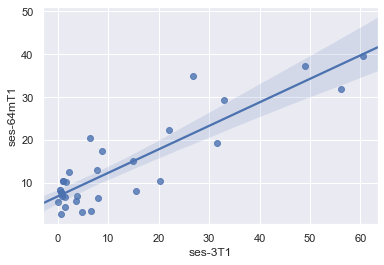

In [24]:
# correlate 3T1 and 64mT volumes
sns.set_theme(color_codes=True)
ax = sns.regplot(x="ses-3T1", y="ses-64mT1", data=volumes_df, truncate=False)
r, p = scipy.stats.pearsonr( volumes_df['ses-3T1'], volumes_df['ses-64mT1'])
fig = ax.get_figure()
fig.savefig('../output/manuscript_figures/raw_figures/fig4A.tif', dpi=600)
print('Pearson\'s corr: R = '+ str(r) + ' P = ' + str(p) )

#### Fig 4B

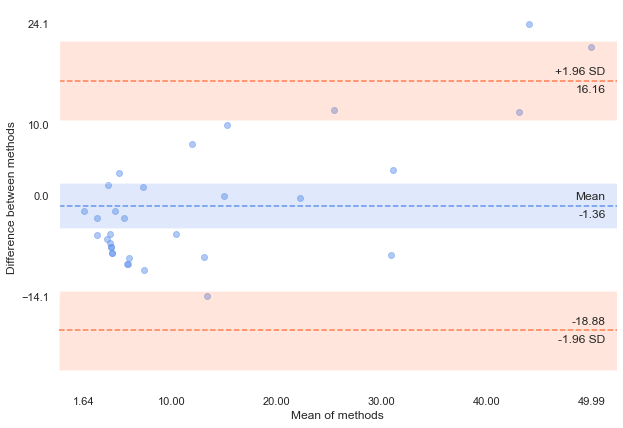

Standard Error of Measurement (SEM) =  5.19270767593281
R = 0.7318178905754702 P = 1.9419350579790947e-06


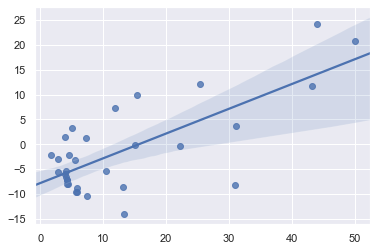

In [25]:
# Bland-Altman using pyCompare
pyCompare.blandAltman(volumes_df['ses-3T1'], volumes_df['ses-64mT1'], dpi=600, savePath='../output/manuscript_figures/raw_figures/fig4B.tif',figureFormat='tif') # save figure
pyCompare.blandAltman(volumes_df['ses-3T1'], volumes_df['ses-64mT1'])

# calculate SEM (standard error of measurement)
volumes_df['std'] = volumes_df[['ses-3T1','ses-64mT1']].std(axis=1)
SEM = np.mean( volumes_df['std'] )
print('Standard Error of Measurement (SEM) = ', str(SEM) )

# get correlation
y = volumes_df['ses-3T1']-volumes_df['ses-64mT1']
x = (volumes_df['ses-3T1']+volumes_df['ses-64mT1'])/2
ax = sns.regplot(x=x, y=y, truncate=False)
r, p = scipy.stats.pearsonr( x, y)
print('R = ' + str(r) +' P = ' + str(p) )



### Automated Segmentation Overlap

Across patients, there was a wide range in overlap between 3T and 64mT segmentation pairs (Dice: mean=0.24, max=0.65, min=0), with automated segmentations overlapping in 91% (29/32) of patients. To characterize the full range of segmentation quality across the dataset, Figure E4 illustrates segmentations from each quartile of the Dice distribution. Larger lesion size is frequently associated with higher Dice (23). We found in our dataset that total lesion burden at 3T was highly correlated with Dice (r=0.80, p<0.001).


#### Rigid registration of 64mT and 3T imaging, calculate overlap

In [26]:
N = len(volumes_df)
DSC = []
subs = []
lesions_df = pd.DataFrame(columns=['sub_ID', 'lesion_ID', 'vol', 'overlap','intensity'])

for sub in os.listdir('../analysis/mimosa_v4.1/'):
    
    # ignore none data items
    if sub[0] == '.':
        continue
    elif sub == 'sub-P002': # HV
        continue
    elif sub == 'sub-P010': # CIS
        continue
    elif sub == 'sub-P030': # CIS
        continue
    elif sub == 'sub-P022': # NMO
        continue
    else:
    
        # load in 3T1 FLAIR image
        file = '../analysis/mimosa_v4.1/' + sub + '/ses-3T1/flair_n4_reg2t1n4.nii.gz'
        fixed = ants.image_read(file)
        file = '../analysis/mimosa_v4.1/' + sub + '/ses-3T1/mimosa_binary_mask_0.2*.nii.gz'
        file = glob.glob(file)[0]    
        mask = ants.image_read(file)
        mask_3T1 = mask # store for DSC w/ 64mT later

        ### coregister 64mT ###

        # load in 64mT FLAIR image
        file = '../analysis/mimosa_v4.1/' + sub + '/ses-64mT1/flair_n4_reg2t1n4.nii.gz'
        moving = ants.image_read(file)
        file = '../analysis/mimosa_v4.1/' + sub + '/ses-64mT1/mimosa_binary_mask_0.2*.nii.gz'
        file = glob.glob(file)[0]   
        mask = ants.image_read(file)

        mytx = ants.registration(fixed=fixed , 
                                 moving=moving, 
                                 type_of_transform='Rigid' ) # rigid regisration

        # warp binary mask to 3T1 space
        warped_img = ants.apply_transforms( fixed=fixed, 
                                              moving=moving, 
                                              transformlist=mytx['fwdtransforms'], 
                                              interpolator='linear')
        
        warped_mask = ants.apply_transforms( fixed=fixed, 
                                              moving=mask, 
                                              transformlist=mytx['fwdtransforms'], 
                                              interpolator='nearestNeighbor')

        # load in 64mT FLAIR image w/ white stripe
        file = '../analysis/mimosa_v4.1/' + sub + '/ses-64mT1/flair_ws.nii.gz'
        moving = ants.image_read(file)
        warped_img = ants.apply_transforms( fixed=fixed, 
                                              moving=moving, 
                                              transformlist=mytx['fwdtransforms'], 
                                              interpolator='linear')
        
        # calculate DSC
        DSC.append( dice(warped_mask.numpy(), mask_3T1.numpy()) )
        subs.append( sub )
        
        # add dataFrame
        subject_df = lesion_overlap_intensity(mask_3T1.numpy(), warped_mask.numpy(), warped_img.numpy())
        subject_df['sub_ID'] = sub
        lesions_df = lesions_df.append(subject_df)
        
        # write out warped images
        filename = '../analysis/mimosa_v4.1/' + sub + '/ses-3T1/mimosa_binary_reg2lowfield.nii.gz'
        ants.image_write(warped_mask, filename)
        filename = '../analysis/mimosa_v4.1/' + sub + '/ses-3T1/flair_n4_reg2lowfield.nii.gz'
        ants.image_write(warped_img, filename)

# convert volumes ml
lesions_df['vol (ml)'] = lesions_df['vol'] * 0.001 # convert to ml  

# add DSC to table and print
volumes_df['DSC'] = DSC
volumes_df.sort_values(by=['DSC'])

,ses-3T1,ses-64mT1,std,DSC
ID,,,,
sub-P007,0.055000,5.618981,3.934328,0.000000
sub-P044,0.348091,8.345274,5.654862,0.000000
sub-P012,0.604000,2.675096,1.464486,0.000000
sub-P045,0.856400,6.860532,4.245563,0.001992
sub-P038,0.649452,7.802925,5.058270,0.002006
sub-P011,2.191000,12.556310,7.329381,0.018086
sub-P032,1.346588,4.394100,2.154916,0.020256
sub-P013,0.787000,7.398111,4.674762,0.028540
sub-P006,0.332000,8.332475,5.657190,0.035783


#### box-plot of Dice score and basic stats

DSC: 0.23 +/- 0.21
Max: 0.6466710714340591 , Min: 0.0
Subjects w/ segmentation overlap: 91.0%


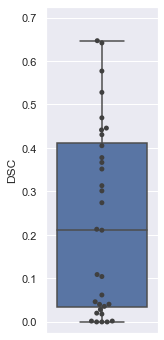

In [27]:
mean_std(volumes_df,'DSC', 2)
print('Max: ' + str(np.max(volumes_df['DSC'])) +' , Min: ' + str(np.min(volumes_df['DSC'])) )
fig = plt.figure(figsize = (2,6))
ax = sns.boxplot(y="DSC", data=volumes_df, orient="v")
ax = sns.swarmplot(y="DSC", data=volumes_df, orient="v", color=".25")
fig = ax.get_figure()
plt.axis([-0.5, 0.5, -0.025, 0.725])
fig.savefig('../output/manuscript_figures/raw_figures/figE4.tif', dpi=600)


# print number of subjects with segmentation overlap
N = len(volumes_df['DSC'])
seg_percent = ( N - np.sum(volumes_df['DSC']==0) ) / N
print('Subjects w/ segmentation overlap: '+ str( 100*np.round(seg_percent,2) ) + '%')

#### Plot images with segmentation overlays

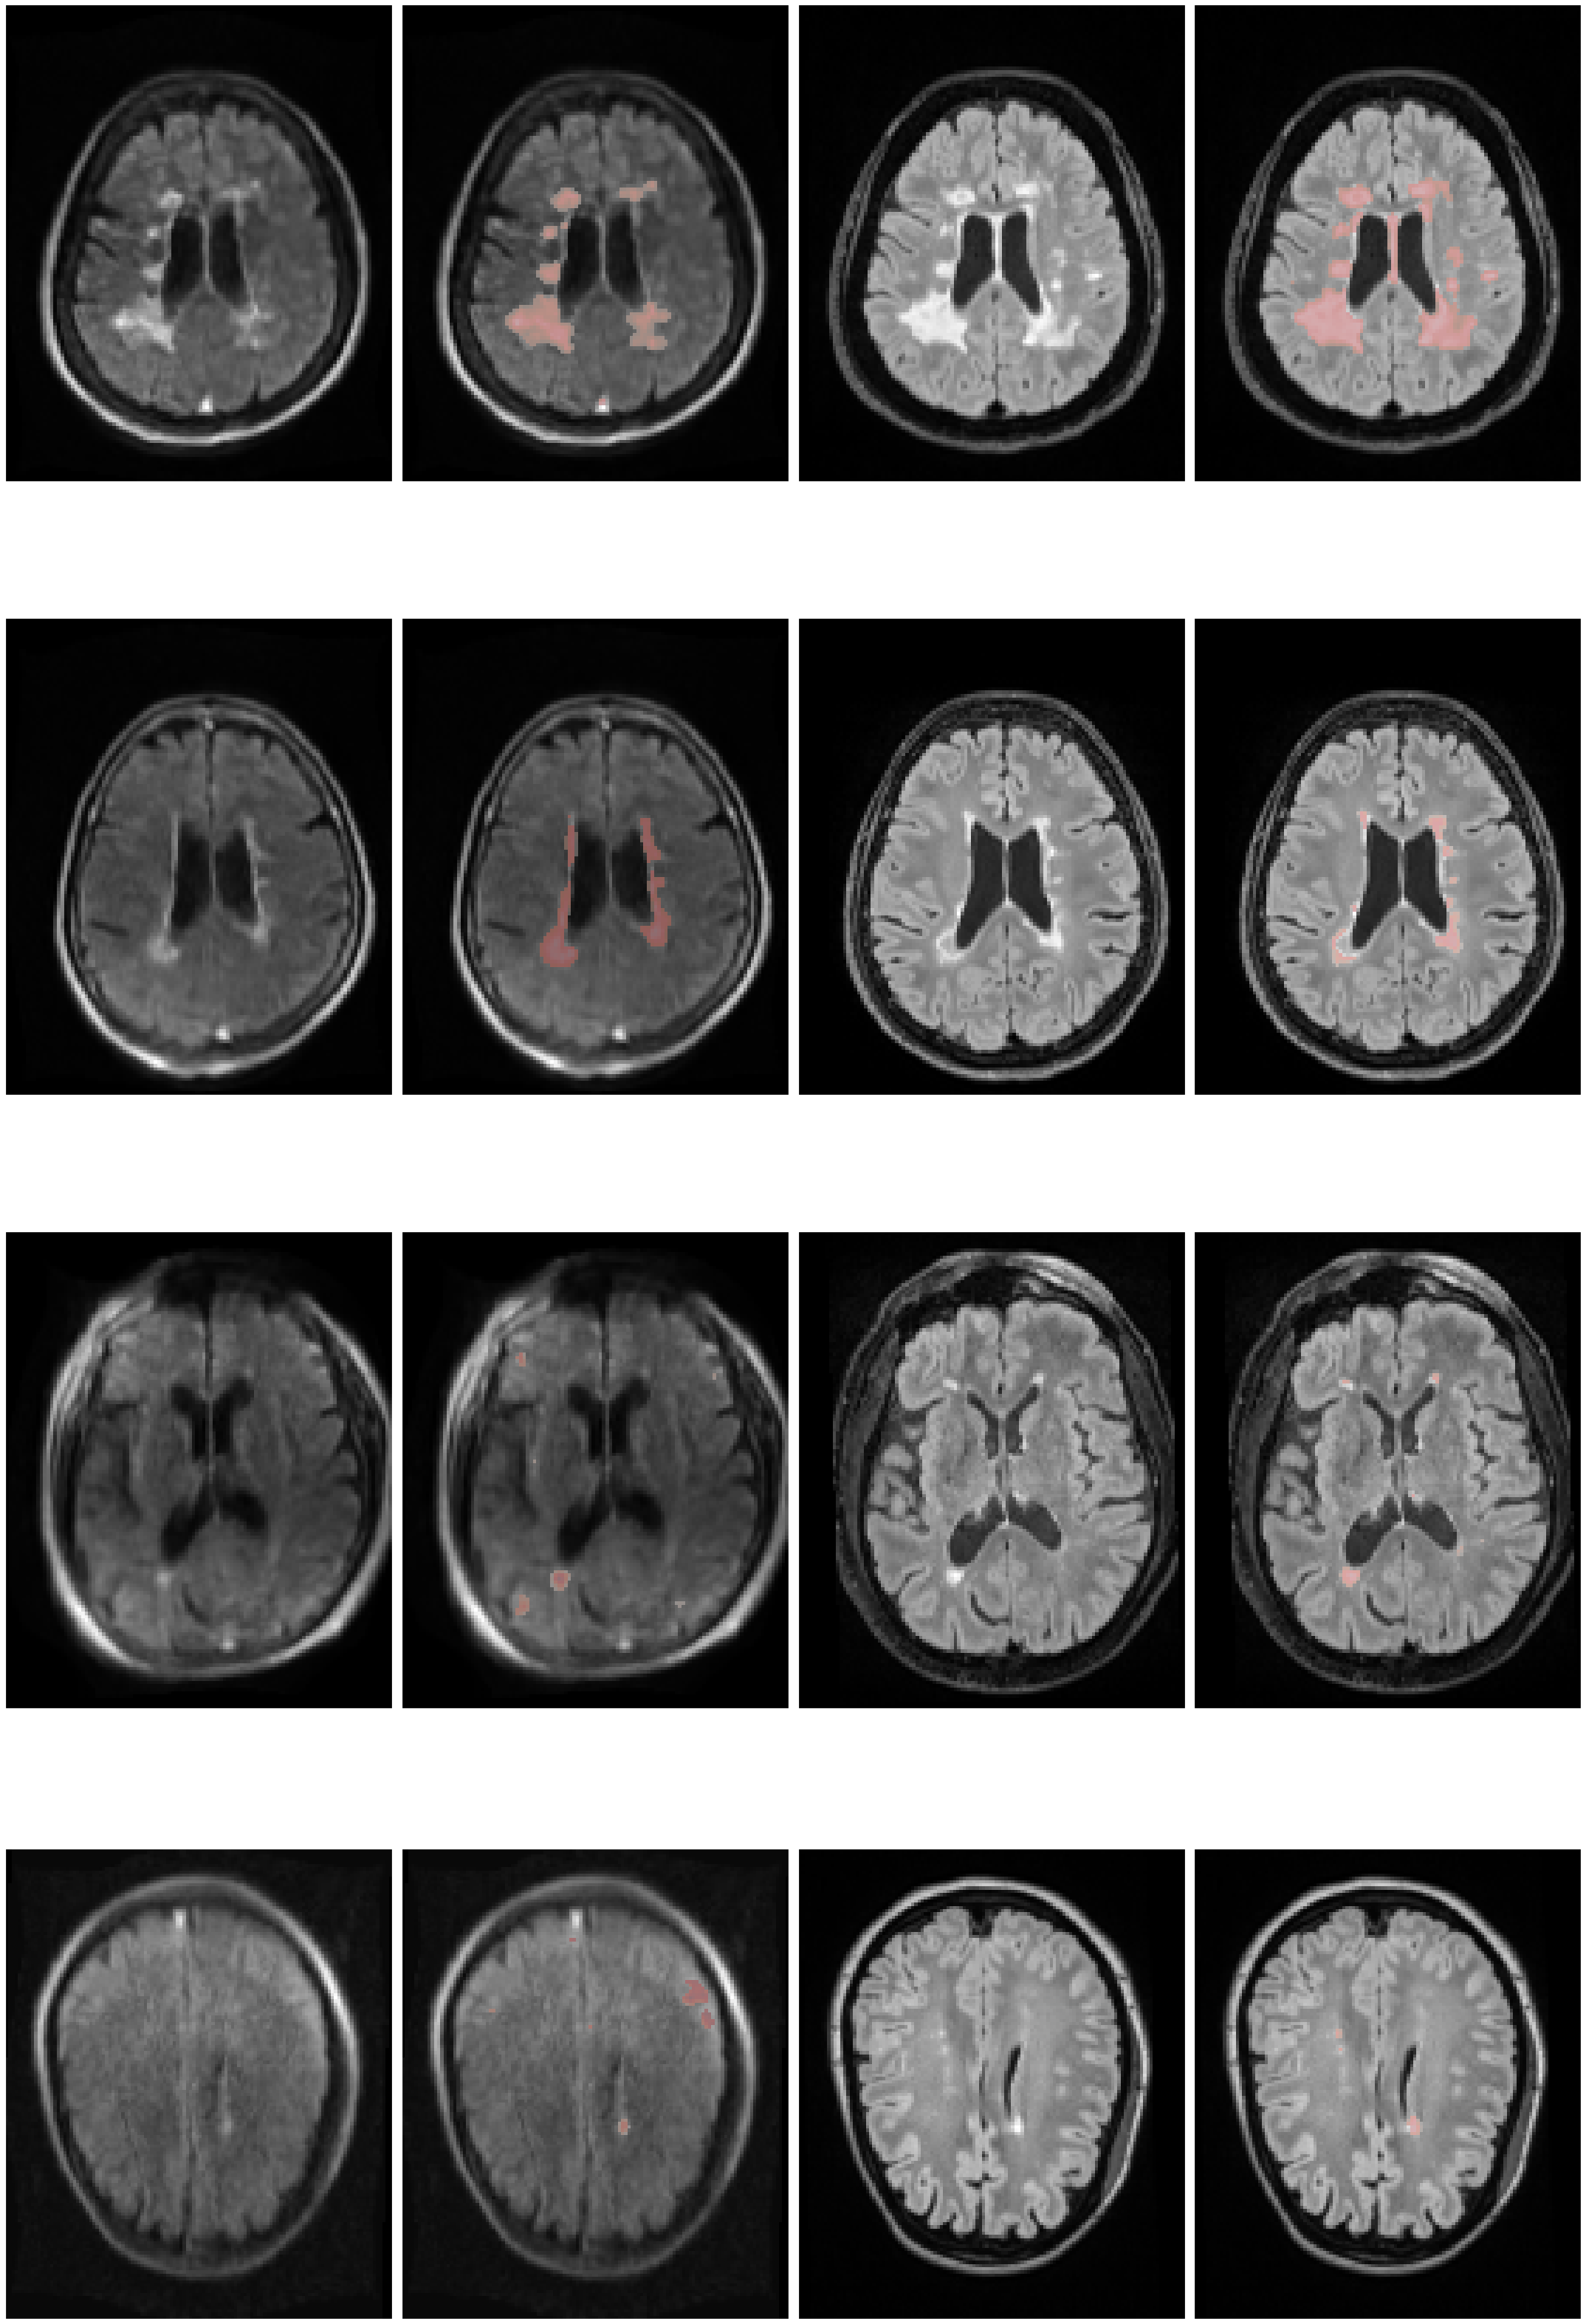

In [28]:
fig = plt.figure(figsize = (30,48)) # create a 5 x 5 figure 

# subjects to plot
subject_IDs = ['sub-P008','sub-P005','sub-P003','sub-P032'] # representative (each quartile of Dice distribution)
#subject_IDs = ['sub-P008','sub-P042','sub-P046'] # best 3
#subject_IDs = ['sub-P007','sub-P011','sub-P044'] # worst 3

N = len(subject_IDs)

n = 0 # loop counter for subplot 
for sub in subject_IDs:
    
    # ignore none data items
    if sub[0] == '.':
        continue
    
    # load in 64mT FLAIR image
    file = '../analysis/mimosa_v4.1/' + sub +'/ses-64mT1/flair_n4_reg2t1n4.nii.gz'
    fixed = ants.image_read(file)
    file = '../analysis/mimosa_v4.1/' + sub + '/ses-64mT1/mimosa_binary_mask_0.2*.nii.gz'
    file = glob.glob(file)[0]      
    mask = ants.image_read(file)
    mask_64mT = mask # store for DSC w/ 3T later
    
    # find slice with maximal lesion burden
    idx = mask_idx( mask )
    idx = mask_idx( mask )
    img = fixed[:,:,idx]
    mask = mask[:,:,idx]
    
    # plot 64mT image
    ax1 = fig.add_subplot(N,4,1+n)
    mask = np.ma.masked_where(mask == 0,img)
    ax1.imshow( np.rot90(img, k=3) , cmap='gray', interpolation='none')
    ax1.grid(False)
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    # plot with segmentation overlay
    ax2 = fig.add_subplot(N,4,2+n)
    mask = np.ma.masked_where(mask == 0,img)
    ax2.imshow(np.rot90(img, k=3), cmap='gray', interpolation='none')
    ax2.imshow(np.rot90(mask, k=3), cmap='Reds', interpolation='none', alpha=0.3)
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    ### coregister 3T ###
    
    # load in 3T1 FLAIR image
    file = '../analysis/mimosa_v4.1/' + sub +'/ses-3T1/flair_n4_reg2t1n4.nii.gz'
    moving = ants.image_read(file)
    file = '../analysis/mimosa_v4.1/' + sub + '/ses-3T1/mimosa_binary_mask_0.2*.nii.gz'
    file = glob.glob(file)[0]      
    mask = ants.image_read(file)
        
    mytx = ants.registration(fixed=fixed , 
                             moving=moving, 
                             type_of_transform='DenseRigid' ) # rigid regisration
    
    # warp binary mask to 3T1 space
    warped_img = ants.apply_transforms( fixed=fixed, 
                                          moving=moving, 
                                          transformlist=mytx['fwdtransforms'], 
                                          interpolator='linear')
    warped_img_slice = warped_img.numpy()[:,:,idx]
    warped_mask = ants.apply_transforms( fixed=fixed, 
                                          moving=mask, 
                                          transformlist=mytx['fwdtransforms'], 
                                          interpolator='nearestNeighbor')
    warped_mask_slice = warped_mask.numpy()[:,:,idx]
    
    # plot
    ax3 = fig.add_subplot(N,4,3+n)
    warped_mask_slice = np.ma.masked_where(warped_mask_slice == 0,warped_img_slice)
    ax3.imshow(np.rot90(warped_img_slice, k=3), cmap='gray',  interpolation='none')
    ax3.grid(False)
    ax3.set_xticks([])
    ax3.set_yticks([])
    
    # plot
    ax4 = fig.add_subplot(N,4,4+n)
    warped_mask_slice = np.ma.masked_where(warped_mask_slice == 0,warped_img_slice)
    ax4.imshow(np.rot90(warped_img_slice, k=3), cmap='gray',  interpolation='none')
    ax4.imshow(np.rot90(warped_mask_slice, k=3), cmap='Reds', interpolation='none', alpha=0.3)
    ax4.grid(False)
    ax4.set_xticks([])
    ax4.set_yticks([])
    n=n+4
    
plt.tight_layout()

#### correlate DSC and lesion volume

Pearson's corr: R = 0.8012240185056715 P = 3.6115843693436264e-08


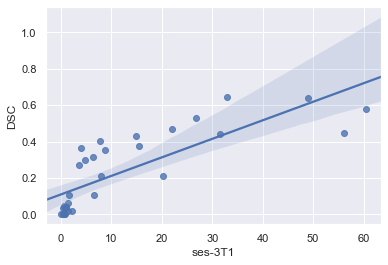

In [29]:
ax = sns.regplot(x="ses-3T1", y="DSC", data=volumes_df, truncate=False)
r, p = scipy.stats.pearsonr( volumes_df['ses-3T1'], volumes_df['DSC'])
print('Pearson\'s corr: R = '+ str(r) + ' P = ' + str(p) )

### Size and Intensity Sensativity

In each segmentation, individual lesions were identified using connected-components analysis (24). For each lesion, volume and mean intensity were quantified. The true-positive rate (TPR) was calculated across a range of lesion size and intensity thresholds (Fig 5). The TPR increases dramatically as lesion size increases, reaching 82% for lesions >0.5 ml and 100% for lesions >1.5 ml. TPR also increases with mean lesion intensity, indicating that lesion intensity also influences the detection rate.





#### Fig 5A

0.8297872340425532
0.9245283018867925
1.0


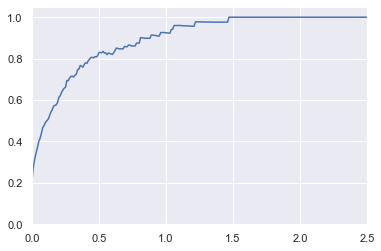

In [30]:
# plot cumulative lesion detection rate as a function of lesion size
sns.set_theme(color_codes=True)
cumf = []
for thres in np.arange(0,np.max(lesions_df['vol (ml)']),0.01):
    data = lesions_df[lesions_df['vol (ml)']>thres]
    N = data.shape[0]
    cumf.append( np.sum(data['overlap']>0) / N ) 
print(cumf[50])
print(cumf[100])
print(cumf[150])
ax = plt.plot(np.arange(0,np.max(lesions_df['vol (ml)']),0.01), cumf)
plt.axis([0, 2.5, 0, 1.05])
plt.savefig('../output/manuscript_figures/raw_figures/fig5A.tif', dpi=600)

#### Fig 5B

Max: 1.0


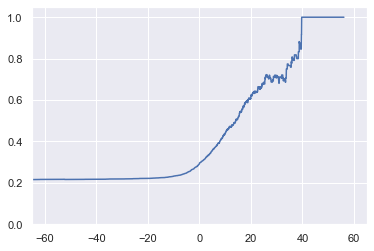

In [31]:
# plot cumulative lesion detection rate as a function of lesion intensity
sns.set_theme(color_codes=True)
cumf = []
for thres in np.arange(np.min(lesions_df['intensity']),np.max(lesions_df['intensity']),0.02):
    data = lesions_df[lesions_df['intensity']>thres]
    N = data.shape[0]
    cumf.append( np.sum(data['overlap']>0) / N )
    
ax = plt.plot(np.arange(np.min(lesions_df['intensity']),np.max(lesions_df['intensity']),0.02), cumf)
plt.axis([-65, 65, 0, 1.05])
plt.savefig('../output/manuscript_figures/raw_figures/fig5B.tif', dpi=600)
print('Max: ' + str(np.max(cumf)))


#### heatmap of volume versus intensity w/ TPR as color

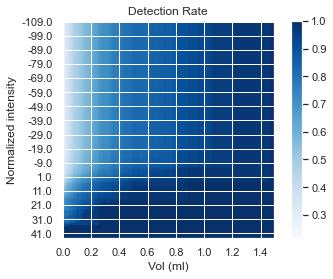

In [32]:
import matplotlib.pyplot as plt 
import pylab as pl

# initialize TPR matrix
thres_int = np.arange(np.min(lesions_df['intensity']),45,1)
thres_vol = np.arange(0,1.5,0.01)
TPR = np.zeros((len(thres_int),len(thres_vol)))

# calculate TPR at all threshold combinations, store as 2D matrix
for i in range(len(thres_int)):
    data = lesions_df[lesions_df['intensity']>thres_int[i]]
    for v in range(len(thres_vol)):
        data2 = data[data['vol (ml)']>thres_vol[v]]
        N = data2.shape[0]
        TPR[i][v] = np.sum(data2['overlap']>0) / N    

# setup figure 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Vol (ml)')
ax.set_ylabel('Normalized intensity')
ax.set_title('Detection Rate')

# volumes axis labels
x_range = np.arange(0, np.max(thres_vol), 0.2)
x_ax_labels = np.round( x_range, 2)
x_ax_ticks = x_ax_labels/ 0.01

# intensity axis labels
y_range = np.arange(np.min(thres_int), np.max(thres_int), 10)
y_ax_labels = np.round( y_range )
y_ax_ticks = y_range - np.min(y_range)

# plot heatmap of TPR based on different thresholds
plt.xticks(ticks=x_ax_ticks,labels=x_ax_labels)
plt.yticks(ticks=y_ax_ticks,labels=y_ax_labels)
plt.imshow(TPR, cmap='Blues',interpolation="spline16")
plt.colorbar()


#### scatter plot of volume versus intensity w/ overlap score as color

<AxesSubplot:xlabel='vol (ml)', ylabel='intensity'>

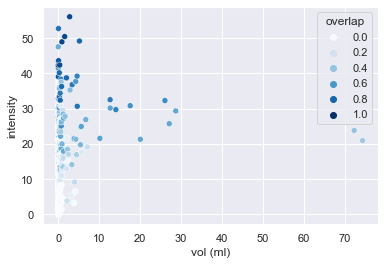

In [33]:
lesions_threshold_df = lesions_df[lesions_df['intensity'] > 0]
sns.scatterplot(data=lesions_threshold_df.sort_values('vol (ml)',ascending=True), x="vol (ml)", y="intensity", hue="overlap",palette="Blues")

### Super Resolution Imaging

In one patient, a 3x4x5 mm (0.06 ml) subcortical lesion was evident near the left middle frontal gyrus on 3T (Fig 6A) but not in a single low-field acquisition (Fig 6D). Using four to eight multi-acquisition volume averages, the lesion was detectable on the low-field system, and lesion intensity relative to contralateral white matter steadily increased with more acquisitions. With eight volume averages, there was a 34% increase in lesion conspicuity, which was equivalent to 69% of 3T conspicuity (Fig 6B). With multi-acquisition image averaging, lesions as small as 0.06 ml were discernible on 64mT scans.


#### print out a single acqusition and the multi-acquisition average for comparison

Single Acquisition


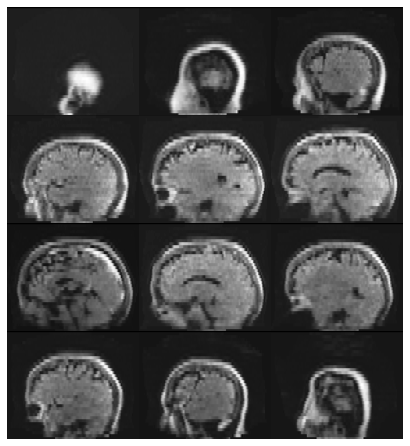

Multi-Acquisition Average


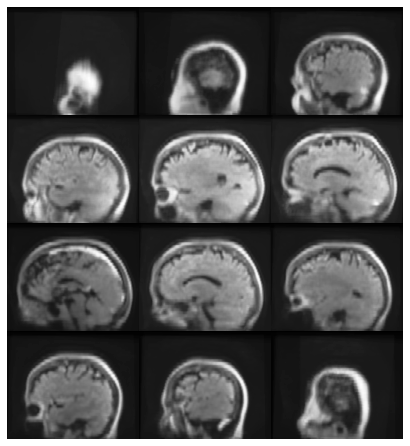

In [34]:
# get root filepath
root = pathlib.Path(r'../data/P045_multiacquisition')

avg_img = []
n = 0

# loop through and iteratively average images
for file in root.rglob('*FLAIR*.nii.gz'):
    
    file = str(file) # convert file to string
    
    # if first image, just reslice and set to fixed
    if n == 0:
        fixed = ants.image_read( file )
        fixed = ants.resample_image(fixed,(1,1,1),False,1) # 1mm isotropic, NearestNeighbor
        cum_img = fixed.numpy()
        
        # plot a single acquistion
        print('Single Acquisition')
        ants.plot( fixed )
        
    else:
        moving = ants.image_read( file )
        moving = ants.resample_image(moving,(1,1,1),False,1) # 1mm isotropic, NearestNeighbor
        mytx = ants.registration(fixed=fixed, moving=moving, type_of_transform = 'TRSAA')
        mywarpedimage = ants.apply_transforms( fixed=fixed, moving=moving,
                                           transformlist=mytx['fwdtransforms'], interpolator='linear')
        cum_img = cum_img + mywarpedimage.numpy()
        
    n=n+1 # increase image counter
        
    # make average
    avg_img = cum_img / n

    # make ants image and plot
    # avg_img = ants.from_numpy( avg_img, origin=fixed.origin, spacing=[1,1,1], direction=fixed.direction)
    avg_img = ants.from_numpy( avg_img, origin=fixed.origin, spacing=fixed.spacing, direction=fixed.direction)

    # save output
    ants.image_write(avg_img, '../analysis/multi-acquisition_average/P045_N' + str(n) + 'avg.nii.gz', ri=True)
    
# plot multi-acquistion average
print('Multi-Acquisition Average')
ants.plot( avg_img )